### Tabel r, r^2, p-value

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import scipy
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan

# Define the range of rows you want to read
start_row = 10  # Starting row (inclusive)
end_row = 35   # Ending row (inclusive)

# Încărcarea fișierului Excel și specificarea numelor celor două foi de lucru
file_path = r'C:\Users\Ricardo Milos\Documents\practica\Indicatori pt coef corelat, coef determinare si pvalue.xlsx'  # Schimbă calea cu locația reală a fișierului
sheet1_name = 'ERL'
sheet2_name = 'GHGLT'

# Read the specific rows from the Excel file
df_GHGET = pd.read_excel(file_path, sheet_name=sheet2_name, index_col=0, skiprows=range(1, start_row), nrows=(end_row - start_row + 1))
df_RTLEL = pd.read_excel(file_path, sheet_name=sheet1_name, index_col=0, skiprows=range(1, start_row), nrows=(end_row - start_row + 1))

# Înlocuirea valorilor ":" cu NaN în tabelul de cheltuieli
df_GHGET.replace(":", np.nan, inplace=True)
df_RTLEL.replace(":", np.nan, inplace=True)

# Gestionarea valorilor lipsă în tabelul de cheltuieli prin completarea cu cea mai apropiată valoare
df_GHGET = df_GHGET.fillna(method='bfill')
df_RTLEL = df_RTLEL.fillna(method='bfill')

# Conversia valorilor în float
df_GHGET = df_GHGET.astype(float)
df_RTLEL = df_RTLEL.astype(float)

def calculate_correlation_statistics(df_RTLEL, df_GHGET):
    # Crearea unui nou DataFrame pentru rezultate
    result_df = pd.DataFrame(columns=['r', 'r^2', 'p-value'])

    # Parcurgerea țărilor care se găsesc în ambele tabele
    common_countries = df_RTLEL.index.intersection(df_GHGET.index)
    for country in common_countries:
        X = df_GHGET.loc[country].values
        y = df_RTLEL.loc[country].values

        # Verificăm dacă cele două variabile sunt constante (toate valorile sunt aceleași)
        if np.all(X == X[0]) or np.all(y == y[0]):
            r = 0         # Setăm coeficientul de corelație la 0 în acest caz
            r_squared = 0  # Setăm coeficientul de determinare la 0 în acest caz
            p_value = 1    # Setăm p-value la 1 (nu este semnificativ)
        else:
            r, _ = stats.pearsonr(X, y)
            r_squared = r**2
            _, p_value = stats.pearsonr(X, y)

        result_df.loc[country] = [r, r_squared, p_value]

    return result_df

# Calcularea statisticilor de corelație și crearea DataFrame-ului cu rezultate
correlation_stats_df = calculate_correlation_statistics(df_RTLEL, df_GHGET)

# Afișarea rezultatelor
print(correlation_stats_df)

                    r       r^2   p-value
Austria      0.400018  0.160014  0.252049
Belgium      0.227912  0.051944  0.526542
Bulgaria     0.381978  0.145907  0.276037
Croatia     -0.350780  0.123047  0.320319
Czechia      0.785569  0.617119  0.007076
Denmark      0.172772  0.029850  0.633143
Estonia      0.215494  0.046438  0.549894
Finland     -0.485587  0.235794  0.154799
France      -0.113382  0.012855  0.755141
Germany     -0.625973  0.391842  0.052862
Greece       0.849195  0.721132  0.001878
Hungary     -0.820937  0.673938  0.003602
Ireland     -0.262584  0.068950  0.463591
Italy       -0.100679  0.010136  0.781983
Latvia       0.474333  0.224992  0.166022
Lithuania    0.864265  0.746954  0.001257
Luxembourg   0.715581  0.512056  0.019969
Netherlands -0.612783  0.375502  0.059619
Poland      -0.461671  0.213140  0.179216
Portugal    -0.762073  0.580756  0.010401
Romania      0.581524  0.338170  0.077840
Slovakia     0.434104  0.188447  0.210021
Slovenia     0.899504  0.809108  0

### Test Breusch-Pagan

In [13]:
def breusch_pagan_test(df_GHGET, df_RTLEL, correlation_matrix, threshold=0.5):
    # List to store countries that meet the threshold
    significant_countries = []

    for country, values in correlation_matrix.iterrows():
        p_val = values['p-value']
        if p_val < threshold and country in df_GHGET.index and country in df_RTLEL.index:
            # Perform the Breusch-Pagan test for heteroscedasticity
            X = df_RTLEL.loc[country].values
            y = df_GHGET.loc[country].values.reshape(-1, 1)
            y = sm.add_constant(y)  # Add a constant column to the independent variable
            
            _, p_value, _, _ = het_breuschpagan(X - np.mean(X), y)
            
            model = sm.OLS(X, y).fit()
            bp_test = het_breuschpagan(model.resid, model.model.exog)
            labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
            print("Country: ", country)
            print(dict(zip(labels, bp_test)), end = '\n\n')

            # Check if both LM-test p-value and F-test p-value are greater than 0.05
            if bp_test[1] > 0.05 and bp_test[3] > 0.05:
                significant_countries.append((country, p_value))    
    return significant_countries

# Specify the threshold for p-value from the correlation test
p_value_threshold = 0.05  # Set this threshold as 0.05

# Perform Breusch-Pagan test for countries with p-value < 0.05 from correlation test
significant_countries = breusch_pagan_test(df_GHGET, df_RTLEL, correlation_stats_df, threshold=p_value_threshold)

# Print the countries that meet the threshold
print("\n\nCountries with p-value < 0.05 in Pearson correlation and significant Breusch-Pagan test:")
for country, p_value in significant_countries:
    print(f"{country}: p-value = {p_value:.4f}")

Country:  Czechia
{'LM Statistic': 0.43022501893420606, 'LM-Test p-value': 0.511878555543325, 'F-Statistic': 0.35965319542866986, 'F-Test p-value': 0.5652934701928842}

Country:  Greece
{'LM Statistic': 0.6217839341195142, 'LM-Test p-value': 0.4303851364652551, 'F-Statistic': 0.5304070025698533, 'F-Test p-value': 0.4872034717387959}

Country:  Hungary
{'LM Statistic': 4.883630138244276, 'LM-Test p-value': 0.027112541004016777, 'F-Statistic': 7.636086162963081, 'F-Test p-value': 0.024547560031987707}

Country:  Lithuania
{'LM Statistic': 0.1279969662379099, 'LM-Test p-value': 0.72051796031588, 'F-Statistic': 0.10372522439481623, 'F-Test p-value': 0.7556590318240313}

Country:  Luxembourg
{'LM Statistic': 0.012448986835498221, 'LM-Test p-value': 0.9111603732665314, 'F-Statistic': 0.009971603103975206, 'F-Test p-value': 0.9229141828849368}

Country:  Portugal
{'LM Statistic': 6.46574258216146, 'LM-Test p-value': 0.01099736774897741, 'F-Statistic': 14.635589472406318, 'F-Test p-value': 0.0

### Calcularea ecuatiilor de regresie

Country: Czechia
Regression Equation: y = 61787.0021 * x - 192472500.6023


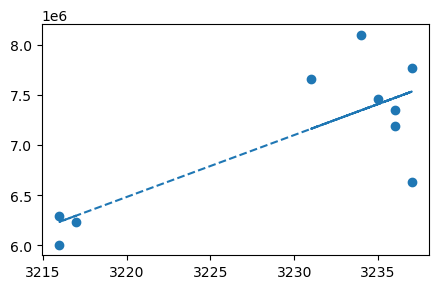

⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺

Country: Greece
Regression Equation: y = 2875.8582 * x + 1910116.8276


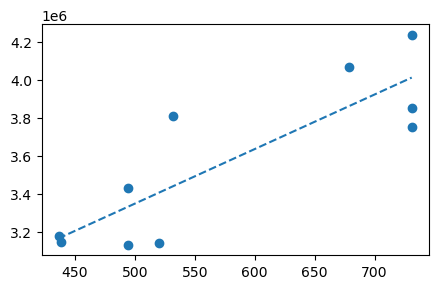

⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺

Country: Lithuania
Regression Equation: y = 115385.1634 * x - 10980923.9174


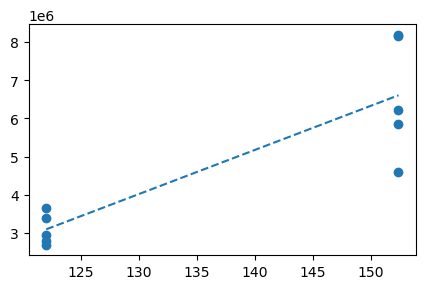

⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺

Country: Luxembourg
Regression Equation: y = 5616.2628 * x - 1247153.6232


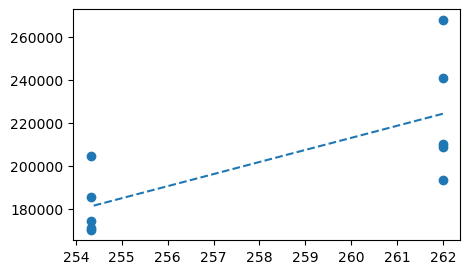

⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺

Country: Slovenia
Regression Equation: y = 1462.1438 * x - 170688.2240


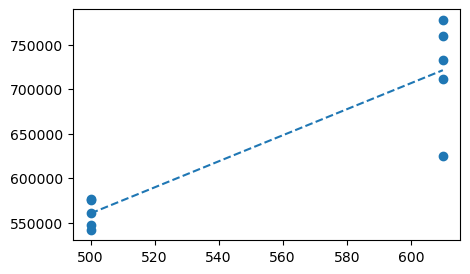

⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺

Country: Spain
Regression Equation: y = 1865.3384 * x + 5404782.9629


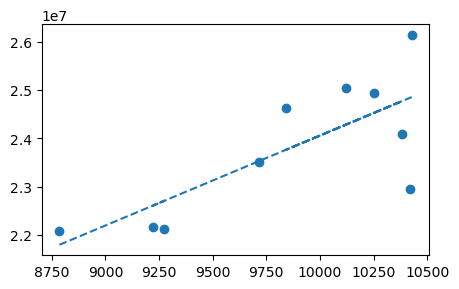

⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺⸺



In [14]:
import matplotlib.pyplot as plt

def perform_regression(df_GHGET, df_RTLEL, significant_countries):
    regression_results = {}

    for country, p_value in significant_countries:
        X_flat = df_RTLEL.loc[country].values
        X = X_flat.reshape(-1, 1)
        y = df_GHGET.loc[country].values
        
        
        regression_model = LinearRegression()
        regression_model.fit(X, y)
        
        # Extract slope and intercept
        slope = regression_model.coef_[0]
        intercept = regression_model.intercept_
        
        # Print values
        print('Country:', country)
        
        # Display the equation of the regression line
        if intercept < 0:
            print(f'Regression Equation: y = {slope:.4f} * x - {-intercept:.4f}')
        else:
            print(f'Regression Equation: y = {slope:.4f} * x + {intercept:.4f}')
        
        plt.figure(figsize=(5,3))
        plt.scatter(X_flat, y)
        y_pred = regression_model.predict(X)
        plt.plot(X_flat, y_pred, linestyle='dashed')
        plt.show()
        print('⸺' * 25, end = '\n\n')
        
        
        
# Perform regression for countries passing the Breusch-Pagan test
regression_results = perform_regression(df_GHGET, df_RTLEL, significant_countries)
    